# Jupyter Notebook to Orchestrate the Strategy based on the 90% C.R
This notebook demonstrates how to use the `tilepy` package to process a skymap, obtain its 90% C.R. and decide which strategy to use 

We will:
1. Load different map types using the `MapReader` interface.
2. Create corresponding `SkyMap` objects.
3. Compute 90% containment areas.
4. Select the strategy out of `wobble`, `redundant` and `complementary`. 

In our case, the boundaries are selected as `wobble < 10 deg^2`,`redundant >10 deg^2 and <60deg^2`,  `complementary>60deg^2`

In [1]:
import healpy as hp
import numpy as np
from tilepy.include.MapManagement import MapReader, SkyMap
from tilepy.include.MapManagement.MapReader import create_map_reader
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule, GetUniversalSchedule
from tilepy.include.PointingTools import  NextWindowTools
from tilepy.include.CampaignDefinition import ObservationParameters 
import time
import argparse
import os
from pathlib import Path
import datetime

/opt/miniconda3/envs/tilepy3/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# 🔵 Testing Tiling Strategy Identification with a Fermi-GBM GRB 

In [2]:
# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
skymap ='https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
obsTime = datetime.datetime.fromisoformat("2023-06-10 14:51:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
pointingsFile = None

In [3]:
# Args are parsed 
obspar_locprob = ObservationParameters()
obspar_locprob.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_locprob.from_configfile(cfgFile)
obspar_locprob.skymap = skymap
obspar_locprob.event_name = "early_gbm"


In [ ]:
# Reads and manages the skymap. Obtains the 90% containment area. Let's find the most probable pixel
reader = create_map_reader(obspar_locprob)
skymap = SkyMap(obspar_locprob, reader)
size90 = skymap.getArea(0.9)
max_coord = skymap.getMaximumProbabilityCoordinates()
print(f"Max probability location: RA = {max_coord.ra.deg:.3f} deg, Dec = {max_coord.dec.deg:.3f} deg")

The filename is glg_healpix_all_bn240612503_v00.fit
The file exists, it will be re-downloaded


In [ ]:
obspar_gauss = ObservationParameters()
obspar_gauss.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_gauss.from_configfile(cfgFile)
obspar_gauss.mode = "gaussian"
obspar_gauss.raSource = max_coord.ra.deg
obspar_gauss.decSource = max_coord.dec.deg
obspar_gauss.sigmaSource = 3.
obspar_gauss.nside = 512

reader_gauss = create_map_reader(obspar_gauss)
skymap_gauss = SkyMap(obspar_gauss, reader_gauss)


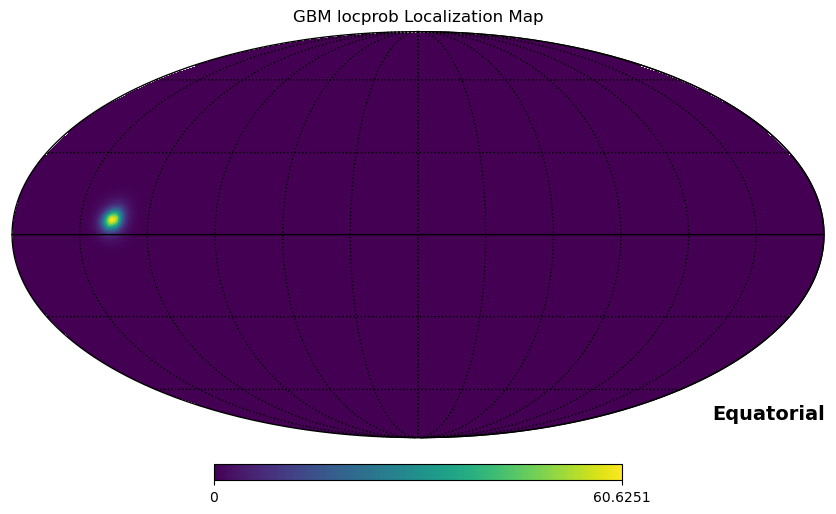

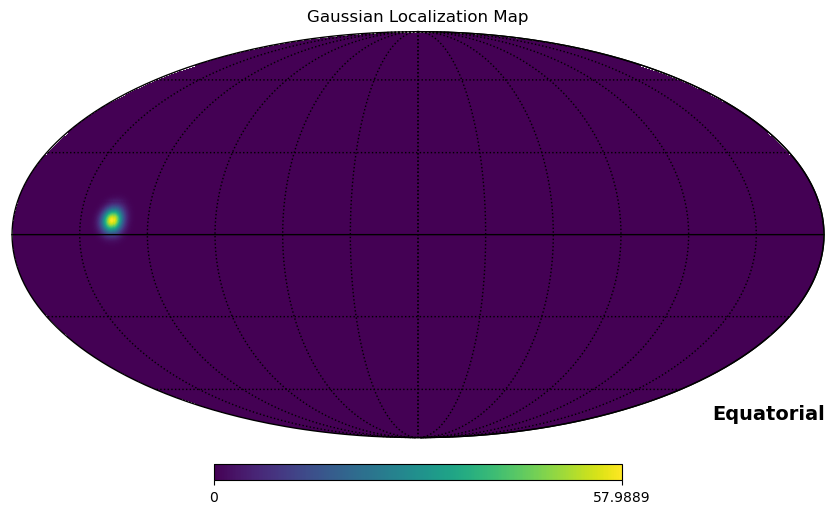

In [ ]:
#Checking that it works! 
import matplotlib.pyplot as plt
hp.mollview(reader.getMap("prob").data, title="GBM locprob Localization Map",rot=[180, 0],
            coord="C",nest = True)
hp.graticule()

# Plot Gaussian Localization Map
hp.mollview(reader_gauss.getMap("prob").data, title="Gaussian Localization Map",rot=[180, 0],
            coord="C", nest = True)
hp.graticule()


# The orchestrator is here:


In [ ]:
def StrategyOrchestrator(obspar, skymap, cutWobble = None, region = 0.9):
    ''' Strategy orchestrator: Decides the best pointing strategy based on the skymap size

    Inputs: obspar (ObservationParameters object), skymap (SkyMap object), cutWobble (float, in deg2, optional), region (float, proportion, optional)
    Outputs: strategy (str) 
    '''

    strategy = None  

    # Identify the number of configurations
    try:
        n = len(obspar)
        print("Number of elements:", n)
    except TypeError:
        n = 1
    
    # If cutWobble is not provided, defaults sets it to twice the FoV area of the telescope
    if cutWobble == None:
        from math import pi
        cutWobble = 2* obspar.FOV**2 * pi      # in deg2

    size = skymap_gauss.getArea(region)
    print(f"The {region*100}% containment area is {size.value:.2f} deg2, CutWobble is {cutWobble:.2f} deg2")
    if size.value <= cutWobble:
        strategy == 'wobble'  # 'wobble', 'complementary', 'reduntant'
        # Find most probable pixel
        max_coord = skymap.getMaximumProbabilityCoordinates(obspar)
        print(f"Max probability location: RA = {max_coord.ra.deg:.3f} deg, Dec = {max_coord.dec.deg:.3f} deg")

    elif n == 1 and size.value > cutWobble:
        strategy == 'redundant'  # 'wobble', 'complementary', 'reduntant'
        GetSchedule(obspar) 
    else:
        strategy =='complementary'  # 'wobble', 'complementary', 'reduntant'
        GetUniversalSchedule(obspar)
    
    return strategy

##  🚀✨ Testing the orchestrator for all cases 

In [ ]:
## Wobble case
StrategyOrchestrator(obspar_gauss, skymap_gauss, cutWobble=1000)
obspar_gauss.raSource




The 90.0% containment area is 129.95 deg2, CutWobble is 1000.00 deg2


UnboundLocalError: cannot access local variable 'max_coord' where it is not associated with a value

In [ ]:
print(f"Max probability location: RA = {max_coord.ra.deg:.3f} deg, Dec = {max_coord.dec.deg:.3f} deg")


Max probability location: RA = 316.055 deg, Dec = 5.379 deg
